In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [4]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [5]:
structure.head(10)

molecule_name  atom_index atom                  x                  y  \
0  dsgdb9nsd_000001           0    C -0.012695312500000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.002149581909180 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.011718750000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.541015625000000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.523925781250000  1.437500000000000   
5  dsgdb9nsd_000002           0    N -0.040435791015625  1.024414062500000   
6  dsgdb9nsd_000002           1    H  0.017257690429688  0.012542724609375   
7  dsgdb9nsd_000002           2    H  0.916015625000000  1.358398437500000   
8  dsgdb9nsd_000002           3    H -0.520507812500000  1.343750000000000   
9  dsgdb9nsd_000003           0    O -0.034362792968750  0.977539062500000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000  
5  0.062561035156250  
6 -0.027374267578125  
7 -0.028762817382812  
8 -0.775390625000000  
9  0.007602691650391

In [6]:
magnetic.shape

(1533537, 11)

In [7]:
potential.head()

molecule_name  potential_energy
0  dsgdb9nsd_000001         -40.53125
1  dsgdb9nsd_000002         -56.56250
2  dsgdb9nsd_000003         -76.43750
3  dsgdb9nsd_000005         -93.43750
4  dsgdb9nsd_000007         -79.81250

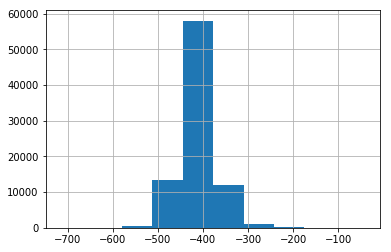

In [8]:
potential.potential_energy.hist()

In [9]:
magnetic.head()

molecule_name  atom_index          XX            YX                 ZX  \
0  dsgdb9nsd_000001           0  195.375000  0.0000000000 -0.000100016593933   
1  dsgdb9nsd_000001           1   31.343750 -1.2314453125  4.054687500000000   
2  dsgdb9nsd_000001           2   31.578125  1.2177734375 -4.148437500000000   
3  dsgdb9nsd_000001           3   31.515625  4.1093750000  1.272460937500000   
4  dsgdb9nsd_000001           4   31.406250 -4.0937500000 -1.179687500000000   

             XY          YY                 ZY                 XZ  \
0  0.0000000000  195.375000  0.000699996948242 -0.000100016593933   
1 -1.2314453125   28.953125 -1.717773437500000  4.054687500000000   
2  1.2177734375   28.906250 -1.603515625000000 -4.148437500000000   
3  4.1093750000   33.906250  1.695312500000000  1.272460937500000   
4 -4.0937500000   34.062500  1.625976562500000 -1.179687500000000   

                  YZ          ZZ  
0  0.000699996948242  195.375000  
1 -1.717773437500000   34.093750  
2 -1.603515625000000   33.906250  
3  1.695312500000000   28.953125  
4  1.625976562500000   28.906250

In [10]:
# train['scalar_coupling_constant'].apply(int).value_counts()

In [11]:
y = train['scalar_coupling_constant']

In [12]:
train = pd.read_csv('train_0.csv', index_col=0)
test = pd.read_csv('test_0.csv', index_col=0)

In [13]:
train_1 = pd.read_csv('train_1.csv', index_col=0)
test_1 = pd.read_csv('test_1.csv', index_col=0)

In [14]:
train = pd.concat([train, train_1], axis=1)
test = pd.concat([test, test_1], axis=1)


In [15]:
train_type = pd.read_csv('input/train.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
test_type = pd.read_csv('input/test.csv.zip', usecols=['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

train['type'] = train_type.type
test['type'] = test_type.type

train['molecule_name'] = train_type.molecule_name
test['molecule_name'] = test_type.molecule_name


In [16]:
train['atom_index_0'] = train_type.atom_index_0
test['atom_index_0'] = test_type.atom_index_0

train['atom_index_1'] = train_type.atom_index_1
test['atom_index_1'] = test_type.atom_index_1


In [17]:
train = pd.merge(train, scaler, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [18]:
train_babel_feat = pd.read_csv('input/train_ob_charges.csv')
test_babel_feat = pd.read_csv('input/test_ob_charges.csv')


In [19]:
train_babel_feat.shape

(1533537, 15)

In [20]:
train_babel_feat['atom_index_0'] = train_babel_feat.atom_index
train_babel_feat['atom_index_1'] = train_babel_feat.atom_index

test_babel_feat['atom_index_0'] = test_babel_feat.atom_index
test_babel_feat['atom_index_1'] = test_babel_feat.atom_index


In [21]:
bfs =  ['molecule_name', 'atom_index_0'] + ['eem', 'qtpie']

In [22]:
train = train.merge(train_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_0'])

bfs =  ['molecule_name', 'atom_index_1'] + ['eem', 'qtpie']
train = train.merge(train_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_1'])

In [23]:

bfs =  ['molecule_name', 'atom_index_0'] + ['eem', 'qtpie']
test = test.merge(test_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_0'])


In [24]:
bfs =  ['molecule_name', 'atom_index_1'] + ['eem', 'qtpie']
test = test.merge(test_babel_feat[bfs], how = 'left', 
                 on=['molecule_name', 'atom_index_1'])

In [25]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0      x_0      y_0  \
0             1             0  1JHC             1       0  0.00215 -0.00603   
1             1             2  2JHH             1       0  0.00215 -0.00603   
2             1             3  2JHH             1       0  0.00215 -0.00603   
3             1             4  2JHH             1       0  0.00215 -0.00603   
4             2             0  1JHC             2       0  1.01200  1.46400   

         z_0  EN_x  rad_x        ...          atom_n     molecule_name  \
0  0.0019760   2.2   0.43        ...               4  dsgdb9nsd_000001   
1  0.0019760   2.2   0.43        ...               4  dsgdb9nsd_000001   
2  0.0019760   2.2   0.43        ...               4  dsgdb9nsd_000001   
3  0.0019760   2.2   0.43        ...               4  dsgdb9nsd_000001   
4  0.0002766   2.2   0.43        ...               4  dsgdb9nsd_000001   

         fc              sd           pso            dso              eem_x  \
0  83.00000  0.254638671875  1.2587890625  0.27197265625  0.161131359327947   
1 -11.03125  0.353027343750  2.8574218750 -3.43359375000  0.161131359327947   
2 -11.03125  0.353027343750  2.8593750000 -3.43359375000  0.161131359327947   
3 -11.03125  0.353027343750  2.8593750000 -3.43359375000  0.161131359327947   
4  83.00000  0.254638671875  1.2587890625  0.27197265625  0.161131811379221   

             qtpie_x              eem_y            qtpie_y  
0  0.773439349698371 -0.644530825087479 -3.093806799641671  
1  0.773439349698371  0.161131811379221  0.773442481023162  
2  0.773439349698371  0.161133990721081  0.773463412039650  
3  0.773439349698371  0.161133663659230  0.773461556880489  
4  0.773442481023162 -0.644530825087479 -3.093806799641671  

[5 rows x 124 columns]

In [26]:
train['q_0'] = train['eem_x'] * train['eem_y'] / train['dist'] ** 2
test['q_0'] = test['eem_x'] * test['eem_y'] / test['dist'] ** 2

train['q_1'] = train['qtpie_x'] * train['qtpie_y'] / train['dist'] ** 2
test['q_1'] = test['qtpie_x'] * test['qtpie_y'] / test['dist'] ** 2

In [27]:
scaler.columns

Index(['molecule_name', 'atom_index_0', 'atom_index_1', 'type', 'fc', 'sd',
       'pso', 'dso'],
      dtype='object')

In [28]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

In [29]:
train['dist_0'] = np.linalg.norm(train_p_0 + train_p_1, axis=1)
test['dist_0'] = np.linalg.norm(test_p_0 + test_p_1, axis=1)

train['dist_1'] = np.max(train_p_0 * train_p_1, axis=1)
test['dist_1'] = np.max(test_p_0 * test_p_1, axis=1)

train['dist_2'] = np.min(train_p_0 * train_p_1, axis=1)
test['dist_2'] = np.min(test_p_0 * test_p_1, axis=1)

train['dist_3'] = np.var(train_p_0 * train_p_1, axis=1)
test['dist_3'] = np.var(test_p_0 * test_p_1, axis=1)

In [31]:
train['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')
test['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')

train['d_0'] = np.max(np.abs(train_p_0 - train_p_1), axis=1)
test['d_0'] = np.max(np.abs(test_p_0 - test_p_1), axis=1)


In [33]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [34]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [35]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0      x_0      y_0  \
0             1             0  1JHC             1       0  0.00215 -0.00603   
1             1             2  2JHH             1       0  0.00215 -0.00603   
2             1             3  2JHH             1       0  0.00215 -0.00603   
3             1             4  2JHH             1       0  0.00215 -0.00603   
4             2             0  1JHC             2       0  1.01200  1.46400   

         z_0  EN_x  rad_x    ...                 eem_y            qtpie_y  \
0  0.0019760   2.2   0.43    ...    -0.644530825087479 -3.093806799641671   
1  0.0019760   2.2   0.43    ...     0.161131811379221  0.773442481023162   
2  0.0019760   2.2   0.43    ...     0.161133990721081  0.773463412039650   
3  0.0019760   2.2   0.43    ...     0.161133663659230  0.773461556880489   
4  0.0002766   2.2   0.43    ...    -0.644530825087479 -3.093806799641671   

                 q_0                 q_1             dist_0        dist_1  \
0 -0.176076470226897  -4.056925318751444  1.527446181376614  0.0000158080   
1  0.834380601398988  19.224591655214667  2.511645603028724  0.0021758000   
2  0.834391886573259  19.225111913998976  2.502617066183318 -0.0011631500   
3  0.834390192965639  19.225065802389921  2.508472615109043  0.0017906512   
4 -0.176076964206423  -4.056941743505150  3.873287746897346  1.5899040000   

        dist_2             dist_3         m_0       d_0  
0 -0.006548580  0.000009513357272 -0.00654858  1.092030  
1 -0.008827920  0.000022639489243 -0.00654858  1.470030  
2 -0.008725410  0.000011824401403 -0.00654858  1.453030  
3 -0.008668125  0.000019418994832 -0.00654858  1.443530  
4 -0.012847340  0.566307184646745 -0.01284734  1.024695  

[5 rows x 132 columns]

In [36]:
train.shape

(4658147, 132)

In [37]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 15,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 1,
          'seed': 666,
          'colsample_bytree': 1.0
         }

In [38]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor



In [66]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
#     y_ = np.log(1 + y_.astype(int).map(y_.astype(int).value_counts().to_dict()))
    
    all_pos = np.sum(y_.apply(int).value_counts().index.values > 0)
    
#     if all_pos:
#         y_ = np.log1p(y_)
    
    all_pos = False
    
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name','atom_index',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1', 'fc', 'sd', 'pso', 'dso']]
    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx].astype(int).map(y_train.iloc[train_idx].astype(int).value_counts().to_dict()))
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx].astype(int).map(y_train.iloc[train_idx].astype(int).value_counts().to_dict()).replace([np.inf, -np.inf], np.nan).fillna(-33))

        num_round = 2000
        clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=50)
        
        oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)
        predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 2285.03	valid_1's l1: 2665.73
[1000]	training's l1: 1986.04	valid_1's l1: 2638.6
[1500]	training's l1: 1749.28	valid_1's l1: 2619.38
[2000]	training's l1: 1553.16	valid_1's l1: 2605.94
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 1553.16	valid_1's l1: 2605.94
Fold 2
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 2282.53	valid_1's l1: 2672.57
[1000]	training's l1: 1982.8	valid_1's l1: 2641.32
[1500]	training's l1: 1748.32	valid_1's l1: 2623.39
[2000]	training's l1: 1553.6	valid_1's l1: 2610.42
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 1553.6	valid_1's l1: 2610.42
Fold 3
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 2293.76	valid_1's l1: 2696.48
[1000]	training's l1: 1995.91	valid_1's l1: 2666.56
[1500]	training's l1: 1759.54	valid_1's l1: 2647.76
[2000]	training's l1: 1561.9

Fold 3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[243]	training's l1: 3490.69	valid_1's l1: 3828.17
Fold 4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[291]	training's l1: 3431.97	valid_1's l1: 3879.17
Fold 5
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[358]	training's l1: 3334.95	valid_1's l1: 3862.81
Fold 1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[62]	training's l1: 3277.61	valid_1's l1: 4083.96
Fold 2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[65]	training's l1: 3273.6	valid_1's l1: 3983.91
Fold 3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[64]	training's l1: 3306.82	valid_1's l1: 3974.35
Fold 4
Training until validation scores don't improve for 50 rounds.
Early

In [68]:
train['y_0'] = oof
test['y_0'] = predictions

In [69]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
#     y_ = np.log(1 + y_.astype(int).map(y_.astype(int).value_counts().to_dict()))
    
    all_pos = np.sum(y_.apply(int).value_counts().index.values > 0)
    
#     if all_pos:
#         y_ = np.log1p(y_)
    
    all_pos = False
    
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name','atom_index',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1', 'fc', 'sd', 'pso', 'dso']]
    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 2000
        clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=50)
        if all_pos:
            oof[train_index[valid_idx]] = np.expm1(clf.predict(x_train.iloc[valid_idx], 
                                                               num_iteration=clf.best_iteration))

            predictions[test_index] += np.expm1(clf.predict(test_[features],
                                                            num_iteration=clf.best_iteration)) / n_split

        else:
            oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

            predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 1.02103	valid_1's l1: 1.18511
[1000]	training's l1: 0.842418	valid_1's l1: 1.1095
[1500]	training's l1: 0.723132	valid_1's l1: 1.069
[2000]	training's l1: 0.631554	valid_1's l1: 1.04183
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.631554	valid_1's l1: 1.04183
Fold 2
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 1.02022	valid_1's l1: 1.1837
[1000]	training's l1: 0.840397	valid_1's l1: 1.1066
[1500]	training's l1: 0.720922	valid_1's l1: 1.06533
[2000]	training's l1: 0.631156	valid_1's l1: 1.03901
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.631156	valid_1's l1: 1.03901
Fold 3
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 1.01866	valid_1's l1: 1.18699
[1000]	training's l1: 0.841393	valid_1's l1: 1.1111
[1500]	training's l1: 0.722605	valid_1's l1: 1.07053
[2000]	training's l1

Fold 3
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.125991	valid_1's l1: 0.243158
[1000]	training's l1: 0.0736826	valid_1's l1: 0.231651
[1500]	training's l1: 0.0467253	valid_1's l1: 0.227614
[2000]	training's l1: 0.0309047	valid_1's l1: 0.225883
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.0309047	valid_1's l1: 0.225883
Fold 4
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.125224	valid_1's l1: 0.243041
[1000]	training's l1: 0.0725046	valid_1's l1: 0.232005
[1500]	training's l1: 0.0460526	valid_1's l1: 0.228255
[2000]	training's l1: 0.0304642	valid_1's l1: 0.226498
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.0304642	valid_1's l1: 0.226498
Fold 5
Training until validation scores don't improve for 50 rounds.
[500]	training's l1: 0.125695	valid_1's l1: 0.239459
[1000]	training's l1: 0.0728006	valid_1's l1: 0.228226
[1500]	training's l1: 0.0461648	valid_1's l

In [70]:
predictions

array([ 12.57100297, 195.547131  ,  10.17456553, ...,   5.40453501,
         6.27537216, 123.38366164])

In [71]:
test.shape

(2505542, 128)

In [72]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [73]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [74]:
sub.shape

(2505542, 2)

In [75]:
len(predictions)

2505542

In [76]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.3.2.csv", index=False)

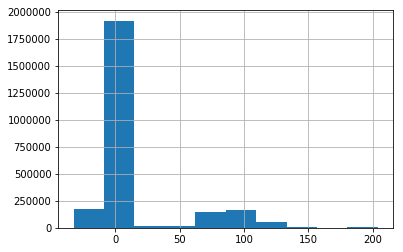

In [77]:
sub['scalar_coupling_constant'].hist()

In [78]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.3.2.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.3.2.csv', index=False)

0          50525
4          50525
7          50525
9          50525
17             1
19         44671
26         44671
32         44671
38         44671
42         44671
45         44671
46         33810
50         33810
53         22617
56         20587
61         20587
65         20587
70          1078
71         20587
76         20587
80         20587
83         29179
88         40687
92         40687
96          6103
105         6242
106        44671
113        44671
119        21939
125        32611
           ...  
4657897     6765
4657904     6691
4657914     6765
4657923     5151
4657932     2976
4657943     6765
4657952     5151
4657953    20600
4657962    20587
4657971     5512
4657980     4558
4657990     4701
4657998     5028
4658009     7089
4658011     9256
4658019     9256
4658028     3978
4658039     3978
4658049     4701
4658057     5151
4658068     4701
4658069     7187
4658076     7187
4658084     5536
4658094     5028
4658104     7089
4658116    33810
4658125    338

In [63]:
np.log(1 + y_train.iloc[valid_idx].astype(int).map(y_train.iloc[train_idx].astype(int).value_counts().to_dict()).fillna(-33))

9          10.609452236806687
53          9.803335670585687
76          9.705341445395202
169        10.207694828570066
187        10.388964598613677
220        10.163001605159987
271         9.772125234339301
322         9.709417248707625
427         8.699181359308954
511        10.609452236806687
515        10.163001605159987
556        10.373459931293572
572         8.634798433490500
601         8.588769389905460
621        10.163001605159987
644        10.163001605159987
725         7.795234929002173
761         7.521859252201629
767         7.314552832324080
787        10.483689974079939
835        10.388964598613677
895        10.551323510386069
901        10.373459931293572
992        10.388964598613677
1009       10.609452236806687
1022       10.609452236806687
1095       10.551323510386069
1099       10.551323510386069
1104        8.513586695822125
1250       10.163001605159987
                  ...        
4656946     8.197263371414335
4656979     8.294549515143679
4657005   